In [1]:
import datetime,warnings,scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['patch.force_edgecolor']=True
plt.style.use('fivethirtyeight')
mpl.rc('patch',edgecolor='dimgray',linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='last_expr' #show last result
pd.options.display.max_columns=50
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

In [3]:
raw_data = pd.read_csv('air_quality.csv',sep=' ')
raw_data.head()

,No,Profile,Tanggal,Jam,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU,Status,Unnamed: 22
0,1,BANDUNG,2019-05-19,00:04:19,21.35,0.78,6.77,14.06,26.168,409.86,251.202,0.0,0.0,0.0,2.77,0.0,21.4,100.0,0.600,5,9,BAIK,NaN
1,2,BANDUNG,2019-05-19,00:15:01,5.93,0.82,14.87,17.23,53.853,394.79,501.356,0.0,0.0,0.0,11.95,0.0,42.6,200.0,0.000,2,12,BAIK,NaN
2,3,BANDUNG,2019-05-19,00:30:06,6.62,0.63,22.24,2.31,38.304,390.66,753.291,0.0,0.0,0.0,12.71,0.0,63.6,299.2,0.000,2,13,BAIK,NaN
3,4,BANDUNG,2019-05-19,00:49:19,13.29,0.44,19.00,5.32,18.962,401.23,251.043,0.0,0.0,0.0,1.20,0.0,21.3,88.2,0.525,5,6,BAIK,NaN
4,5,BANDUNG,2019-05-19,01:04:19,2.44,0.47,26.74,13.61,35.270,381.67,250.471,0.0,0.0,0.0,3.52,0.0,21.3,97.4,0.975,5,9,BAIK,NaN


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9231 entries, 0 to 9230
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   No           9231 non-null   int64  
 1   Profile      9231 non-null   object 
 2   Tanggal      9231 non-null   object 
 3   Jam          9231 non-null   object 
 4   O3           9231 non-null   float64
 5   CO           9231 non-null   float64
 6   NO2          9231 non-null   float64
 7   SO2          9231 non-null   float64
 8   NO           9231 non-null   float64
 9   CO2          9231 non-null   float64
 10  VOC          9231 non-null   float64
 11  PM1          9231 non-null   float64
 12  PM2.5        9231 non-null   float64
 13  PM4          9231 non-null   float64
 14  PM10         9231 non-null   float64
 15  TSP          9231 non-null   float64
 16  TEMP         9231 non-null   float64
 17  HUM          9231 non-null   float64
 18  WS           9231 non-null   float64
 19  WD    

In [5]:
raw_data.isnull().sum()

No                0
Profile           0
Tanggal           0
Jam               0
O3                0
CO                0
NO2               0
SO2               0
NO                0
CO2               0
VOC               0
PM1               0
PM2.5             0
PM4               0
PM10              0
TSP               0
TEMP              0
HUM               0
WS                0
WD                0
ISPU              0
Status            0
Unnamed: 22    9231
dtype: int64

In [6]:
raw_data.insert(loc=2,column='Datetime',value=np.array([x1 + ' ' + x2[0:2] for x1,x2 in zip(raw_data.Tanggal,raw_data.Jam)],dtype='datetime64'))
raw_data.head()

,No,Profile,Datetime,Tanggal,Jam,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU,Status,Unnamed: 22
0,1,BANDUNG,2019-05-19 00:00:00,2019-05-19,00:04:19,21.35,0.78,6.77,14.06,26.168,409.86,251.202,0.0,0.0,0.0,2.77,0.0,21.4,100.0,0.600,5,9,BAIK,NaN
1,2,BANDUNG,2019-05-19 00:00:00,2019-05-19,00:15:01,5.93,0.82,14.87,17.23,53.853,394.79,501.356,0.0,0.0,0.0,11.95,0.0,42.6,200.0,0.000,2,12,BAIK,NaN
2,3,BANDUNG,2019-05-19 00:00:00,2019-05-19,00:30:06,6.62,0.63,22.24,2.31,38.304,390.66,753.291,0.0,0.0,0.0,12.71,0.0,63.6,299.2,0.000,2,13,BAIK,NaN
3,4,BANDUNG,2019-05-19 00:00:00,2019-05-19,00:49:19,13.29,0.44,19.00,5.32,18.962,401.23,251.043,0.0,0.0,0.0,1.20,0.0,21.3,88.2,0.525,5,6,BAIK,NaN
4,5,BANDUNG,2019-05-19 01:00:00,2019-05-19,01:04:19,2.44,0.47,26.74,13.61,35.270,381.67,250.471,0.0,0.0,0.0,3.52,0.0,21.3,97.4,0.975,5,9,BAIK,NaN


In [7]:
raw_data.columns

Index(['No', 'Profile', 'Datetime', 'Tanggal', 'Jam', 'O3', 'CO', 'NO2', 'SO2',
       'NO', 'CO2', 'VOC', 'PM1', 'PM2.5', 'PM4', 'PM10', 'TSP', 'TEMP', 'HUM',
       'WS', 'WD', 'ISPU', 'Status', 'Unnamed: 22'],
      dtype='object')

In [8]:
df = raw_data.drop(columns=['No','Tanggal','Jam','Unnamed: 22'])
df1 = df.groupby(['Datetime']).mean()
df1.head()

,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU
Datetime,,,,,,,,,,,,,,,,,
2019-05-19 00:00:00,11.797500,0.667500,15.720,9.7300,34.32175,399.135000,439.22300,0.0,0.0,0.0,7.157500,0.0,37.225000,171.850000,0.28125,3.500000,10.000000
2019-05-19 01:00:00,3.816667,0.373333,22.600,20.0900,39.82100,388.536667,250.39400,0.0,0.0,0.0,3.293333,0.0,20.966667,95.033333,0.67500,4.666667,12.666667
2019-05-19 02:00:00,6.450000,0.332500,24.130,26.3100,51.29325,396.242500,251.04575,0.0,0.0,0.0,6.487500,0.0,20.150000,97.500000,0.09375,3.750000,16.250000
2019-05-19 03:00:00,4.740000,0.180000,25.975,24.3900,43.51850,401.355000,252.24875,0.0,0.0,0.0,4.700000,0.0,19.850000,100.000000,0.07500,5.000000,15.000000
2019-05-19 04:00:00,19.692500,0.202500,20.395,18.6225,53.37925,399.335000,694.23975,0.0,0.0,0.0,5.262500,0.0,53.475000,272.500000,0.18750,5.250000,13.250000


In [9]:
df1.describe()

,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU
count,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000
mean,8.538909,0.233172,16.681910,12.013894,37.086256,394.616480,260.053778,0.309564,0.383692,0.451982,6.157770,0.562012,25.266942,77.634191,24.291226,7.129031,10.097848
std,3.997292,0.388102,5.373487,4.411251,12.521778,4.180224,60.773321,2.286104,2.874126,3.378291,4.149511,4.184787,6.707977,29.743129,51.993683,3.523245,5.049788
min,0.270000,0.010000,2.040000,2.162500,3.128750,380.420000,187.518000,0.000000,0.000000,0.000000,0.885000,0.000000,11.250000,26.866667,0.000000,0.000000,4.250000
25%,5.881667,0.083333,13.010000,9.015000,28.443500,391.830000,247.798333,0.000000,0.000000,0.000000,4.340000,0.000000,21.266667,57.850000,0.237500,4.666667,8.166667
50%,7.813333,0.160000,15.916667,11.730000,39.252250,394.602000,250.926250,0.000000,0.000000,0.000000,5.571667,0.000000,24.100000,77.083333,1.312500,5.833333,9.500000
75%,10.373333,0.296667,19.935000,14.595000,46.015500,397.415000,253.286667,0.000000,0.000000,0.000000,7.090000,0.000000,28.400000,94.066667,5.075000,10.500000,11.000000
max,33.741667,13.950000,99.600000,46.290000,194.554000,408.820000,1240.713500,51.600000,68.700000,79.800000,91.600000,92.900000,124.600000,313.400000,199.200000,15.000000,156.500000


<Figure size 864x288 with 0 Axes>

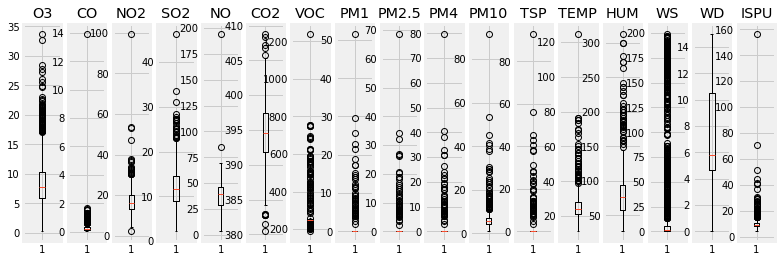

In [10]:
plt.figure(figsize=(12,4))
t = 0
fig,axes = plt.subplots(nrows=1,ncols=len(df1.select_dtypes(include='number').columns),figsize=(12,4))
for i in df1.select_dtypes(include='number').columns:
    axes[t].set_title(i)
    axes[t].boxplot(df1[i])
    t+=1

In [11]:
# calculate quantile
def quantile(i, df1):
        Q1 = df1[[i]].quantile(0.25)[0]
        Q3 = df1[[i]].quantile(0.75)[0]
        IQR = Q3 - Q1
        min = df1[[i]].min()[0]
        max = df1[[i]].max()[0]
        min_IQR = Q1 - 1.5*IQR
        max_IQR = Q3 + 1.5*IQR

        return Q1,Q3,min,max,min_IQR,max_IQR

In [12]:
#interpolate the outliers with linear method
for i in df1.select_dtypes(include='number').columns:
    Q1, Q3, min, max, min_IQR, max_IQR = quantile(i, df1)
    
    if i=='HUM': max_IQR=100
    def convert_nan (x, max_IQR=max_IQR, min_IQR=min_IQR):
        if ((x > max_IQR) | (x < min_IQR)):
            x = np.nan
        else:
            x = x
        return x
    
    df1[i] = df1[i].map(convert_nan)
    df1[i].interpolate(method='linear',inplace=True,limit_direction='both')

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1737 entries, 2019-05-19 00:00:00 to 2019-08-18 23:00:00
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   O3      1737 non-null   float64
 1   CO      1737 non-null   float64
 2   NO2     1737 non-null   float64
 3   SO2     1737 non-null   float64
 4   NO      1737 non-null   float64
 5   CO2     1737 non-null   float64
 6   VOC     1737 non-null   float64
 7   PM1     1737 non-null   float64
 8   PM2.5   1737 non-null   float64
 9   PM4     1737 non-null   float64
 10  PM10    1737 non-null   float64
 11  TSP     1737 non-null   float64
 12  TEMP    1737 non-null   float64
 13  HUM     1737 non-null   float64
 14  WS      1737 non-null   float64
 15  WD      1737 non-null   float64
 16  ISPU    1737 non-null   float64
dtypes: float64(17)
memory usage: 244.3 KB


In [14]:
df1.head()

,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU
Datetime,,,,,,,,,,,,,,,,,
2019-05-19 00:00:00,11.797500,0.373333,15.720,9.730000,34.32175,399.135000,250.39400,0.0,0.0,0.0,7.157500,0.0,37.225000,95.033333,0.28125,3.500000,10.000000
2019-05-19 01:00:00,3.816667,0.373333,22.600,20.090000,39.82100,388.536667,250.39400,0.0,0.0,0.0,3.293333,0.0,20.966667,95.033333,0.67500,4.666667,12.666667
2019-05-19 02:00:00,6.450000,0.332500,24.130,19.600833,51.29325,396.242500,251.04575,0.0,0.0,0.0,6.487500,0.0,20.150000,97.500000,0.09375,3.750000,13.833333
2019-05-19 03:00:00,4.740000,0.180000,25.975,19.111667,43.51850,401.355000,252.24875,0.0,0.0,0.0,4.700000,0.0,19.850000,100.000000,0.07500,5.000000,15.000000
2019-05-19 04:00:00,7.030833,0.202500,20.395,18.622500,53.37925,399.335000,252.22100,0.0,0.0,0.0,5.262500,0.0,18.950000,100.000000,0.18750,5.250000,13.250000


# Temperature Prediction

array([[<AxesSubplot:title={'center':'TEMP'}>,
        <AxesSubplot:title={'center':'log_TEMP'}>]], dtype=object)

<Figure size 864x360 with 0 Axes>

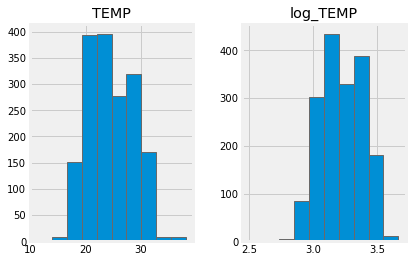

In [15]:
dist_df = pd.DataFrame({'TEMP': df1.TEMP.values,'log_TEMP':np.log1p(df1.TEMP.values)})
plt.figure(figsize=(12,5))
dist_df.hist()

In [16]:
dataset = np.log1p(df1[['TEMP']].values)
train_size = int(len(dataset)*0.75)
test_size = len(dataset) - train_size
train,test = dataset[0:train_size-1],dataset[train_size:len(dataset)]
print(len(train),len(test))

1301 435


In [17]:
def create_dataset(dataset, look_back=1):
    X,Y = [],[]
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back)]
        X.append(a)
        Y.append(dataset[i+look_back])
    return np.array(X),np.array(Y)

In [18]:
BATCH_SIZE = 32
EPOCHS = 1000
VERBOSE = 2
LOOK_BACK = 1

In [19]:
X_train, Y_train = create_dataset(train,LOOK_BACK)
X_test, Y_test = create_dataset(test,LOOK_BACK)
X_train.shape

(1299, 1, 1)

In [20]:
model = Sequential()

model.add(LSTM(4,input_shape=(1,LOOK_BACK)))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,Y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=VERBOSE)

Epoch 1/1000
41/41 - 5s - loss: 12.8257 - 5s/epoch - 119ms/step
Epoch 2/1000
41/41 - 0s - loss: 11.6015 - 222ms/epoch - 5ms/step
Epoch 3/1000
41/41 - 0s - loss: 10.6221 - 220ms/epoch - 5ms/step
Epoch 4/1000
41/41 - 0s - loss: 9.7719 - 225ms/epoch - 5ms/step
Epoch 5/1000
41/41 - 0s - loss: 8.9273 - 229ms/epoch - 6ms/step
Epoch 6/1000
41/41 - 0s - loss: 8.0198 - 235ms/epoch - 6ms/step
Epoch 7/1000
41/41 - 0s - loss: 7.0810 - 227ms/epoch - 6ms/step
Epoch 8/1000
41/41 - 0s - loss: 6.1826 - 228ms/epoch - 6ms/step
Epoch 9/1000
41/41 - 0s - loss: 5.3632 - 228ms/epoch - 6ms/step
Epoch 10/1000
41/41 - 0s - loss: 4.6239 - 228ms/epoch - 6ms/step
Epoch 11/1000
41/41 - 0s - loss: 3.9500 - 233ms/epoch - 6ms/step
Epoch 12/1000
41/41 - 0s - loss: 3.3269 - 278ms/epoch - 7ms/step
Epoch 13/1000
41/41 - 0s - loss: 2.7513 - 228ms/epoch - 6ms/step
Epoch 14/1000
41/41 - 0s - loss: 2.2277 - 228ms/epoch - 6ms/step
Epoch 15/1000
41/41 - 0s - loss: 1.7645 - 224ms/epoch - 5ms/step
Epoch 16/1000
41/41 - 0s - loss:

In [21]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

y_pred_test = np.expm1(y_pred_test)
Y_test = np.expm1(Y_test)
y_pred_train = np.expm1(y_pred_train)
Y_train = np.expm1(Y_train)
    
test_score = math.sqrt(mean_squared_error(Y_test,y_pred_test))
train_score = math.sqrt(mean_squared_error(Y_train,y_pred_train))
print('Train MSE score: %.3f' % train_score)
print('Test MSE score: %.3f' % test_score)

Train MSE score: 2.389
Test MSE score: 3.156


In [22]:
Y_test.std()

4.394272114135978

In [23]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:] = np.nan
trainPredictPlot[LOOK_BACK:len(y_pred_train)+LOOK_BACK:] = y_pred_train
trainPredictPlot

array([[        nan],
       [33.88574219],
       [21.83516312],
       ...,
       [        nan],
       [        nan],
       [        nan]])

In [24]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:] = np.nan
testPredictPlot[len(y_pred_train)+(LOOK_BACK*2)+1:len(dataset)-2,:] = y_pred_test
testPredictPlot

array([[        nan],
       [        nan],
       [        nan],
       ...,
       [22.59160805],
       [        nan],
       [        nan]])

In [25]:
time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLabel = np.array(df1.index, dtype='datetime64[D]')

(1302.0, 1736.0)

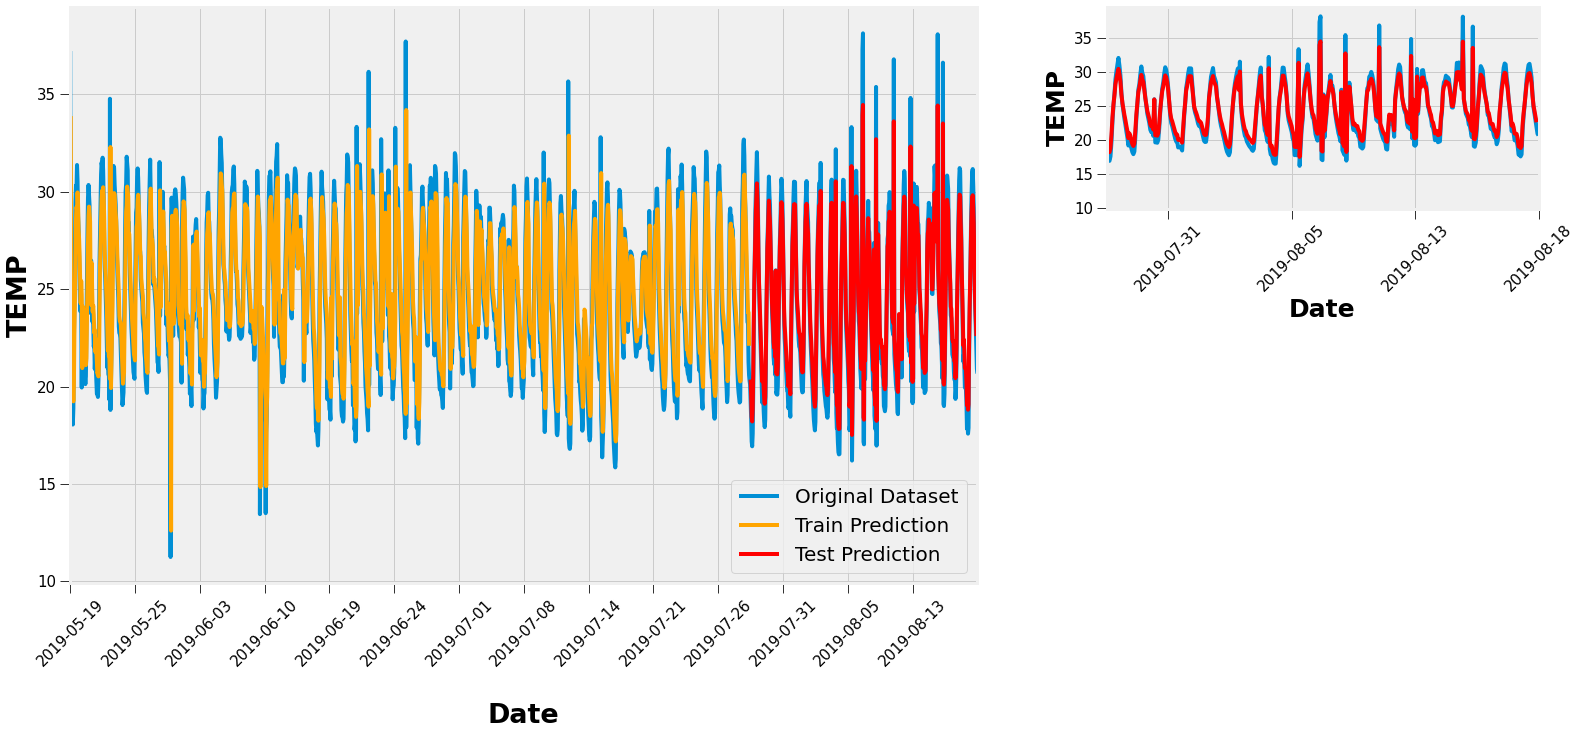

In [26]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLabel[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('TEMP', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,1735])

ax1 = fig.add_axes([2.4,1.3,1,0.7])
ax1.plot(np.expm1(dataset),label='Origin Dataset')
ax1.plot(testPredictPlot,color='r',label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLabel[time_axis],rotation=45)
ax1.set_xlabel('Date',fontsize=25,fontweight='bold')
ax1.set_ylabel('TEMP',fontsize=25,fontweight='bold')
ax1.tick_params(size=10,labelsize=15)
ax1.set_xlim([train_size,len(dataset) - 1])

# PM10 Prediction

array([[<AxesSubplot:title={'center':'PM10'}>,
        <AxesSubplot:title={'center':'log_PM10'}>]], dtype=object)

<Figure size 864x360 with 0 Axes>

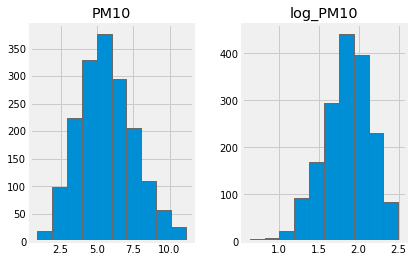

In [27]:
dist_df = pd.DataFrame({'PM10': df1.PM10.values, 'log_PM10':np.log1p(df1.PM10.values)})
plt.figure(figsize=(12,5))
dist_df.hist()

In [28]:
dataset = np.log1p(df1[['PM10']].values)
train_size = int(len(dataset)*0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:,:]

In [29]:
X_train, Y_train = create_dataset(train, LOOK_BACK)
X_test,Y_test = create_dataset(test, LOOK_BACK)
X_train.shape

(1300, 1, 1)

In [30]:
model = Sequential()

model.add(LSTM(4,input_shape=(1,LOOK_BACK)))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,Y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=VERBOSE)

Epoch 1/1000
41/41 - 4s - loss: 3.3432 - 4s/epoch - 105ms/step
Epoch 2/1000
41/41 - 0s - loss: 2.9048 - 136ms/epoch - 3ms/step
Epoch 3/1000
41/41 - 0s - loss: 2.5212 - 122ms/epoch - 3ms/step
Epoch 4/1000
41/41 - 0s - loss: 2.1602 - 128ms/epoch - 3ms/step
Epoch 5/1000
41/41 - 0s - loss: 1.8036 - 133ms/epoch - 3ms/step
Epoch 6/1000
41/41 - 0s - loss: 1.4550 - 127ms/epoch - 3ms/step
Epoch 7/1000
41/41 - 0s - loss: 1.1267 - 125ms/epoch - 3ms/step
Epoch 8/1000
41/41 - 0s - loss: 0.8342 - 126ms/epoch - 3ms/step
Epoch 9/1000
41/41 - 0s - loss: 0.5896 - 129ms/epoch - 3ms/step
Epoch 10/1000
41/41 - 0s - loss: 0.4026 - 127ms/epoch - 3ms/step
Epoch 11/1000
41/41 - 0s - loss: 0.2732 - 132ms/epoch - 3ms/step
Epoch 12/1000
41/41 - 0s - loss: 0.1919 - 124ms/epoch - 3ms/step
Epoch 13/1000
41/41 - 0s - loss: 0.1457 - 129ms/epoch - 3ms/step
Epoch 14/1000
41/41 - 0s - loss: 0.1209 - 124ms/epoch - 3ms/step
Epoch 15/1000
41/41 - 0s - loss: 0.1090 - 129ms/epoch - 3ms/step
Epoch 16/1000
41/41 - 0s - loss: 0.

In [31]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

y_pred_train = np.expm1(y_pred_train)
Y_train = np.expm1(Y_train)
y_pred_test = np.expm1(y_pred_test)
Y_test = np.expm1(Y_test)

train_score = mean_squared_error(Y_train,y_pred_train)
test_score = mean_squared_error(Y_test, y_pred_test)
print('Train MSE score: %.3f' % train_score)
print('Test MSE score: %.3f' % test_score)

Train MSE score: 3.699
Test MSE score: 3.089


In [32]:
Y_test.std()

1.749993103621598

In [33]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[LOOK_BACK:len(y_pred_train)+LOOK_BACK,:] = y_pred_train
trainPredictPlot.shape

(1737, 1)

In [34]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:] = np.nan
testPredictPlot[len(y_pred_train) + (LOOK_BACK*2)+1:len(dataset) -1,:] = y_pred_test
testPredictPlot.shape

(1737, 1)

In [35]:
time_axis = np.array(np.linspace(0,len(dataset)-1,15),dtype=int)
time_axisLabel = np.array(df1.index,dtype='datetime64[D]')

(1302.0, 1736.0)

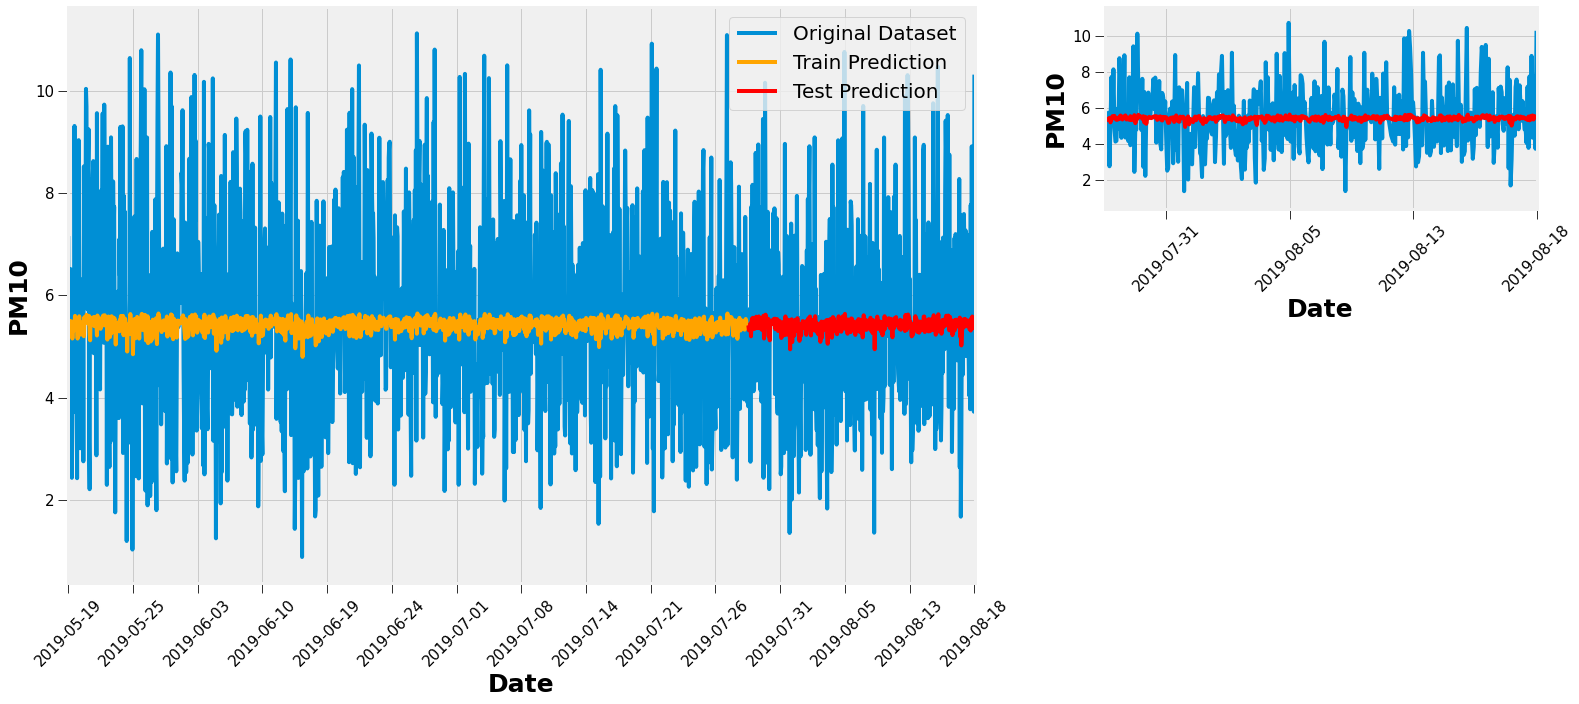

In [36]:
fig =plt.figure()
ax = fig.add_axes([0,0,2.1,2])
ax.plot(np.expm1(dataset),label='Original Dataset')
ax.plot(trainPredictPlot,color='orange',label='Train Prediction')
ax.plot(testPredictPlot,color='red',label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLabel[time_axis],rotation=45)
ax.set_xlabel('Date',fontsize=25,fontweight='bold')
ax.set_ylabel('PM10',fontsize=25,fontweight='bold')
ax.tick_params(size=10,labelsize=15)
ax.legend(loc='best',prop= {'size':20})
ax.set_xlim([-1,len(dataset)])

ax1 = fig.add_axes([2.4, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset),label = 'Original Dataset')
ax1.plot(testPredictPlot, color='r',label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLabel[time_axis],rotation=45)
ax1.set_xlabel('Date',fontsize=25,fontweight='bold')
ax1.set_ylabel('PM10',fontsize=25,fontweight='bold')
ax1.tick_params(size=10,labelsize=15)
ax1.set_xlim([train_size,len(dataset) - 1])

# Humid Prediction

array([[<AxesSubplot:title={'center':'HUM'}>,
        <AxesSubplot:title={'center':'log_HUM'}>]], dtype=object)

<Figure size 864x360 with 0 Axes>

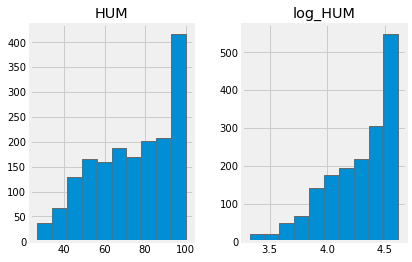

In [37]:
dist_df = pd.DataFrame({'HUM':df1.HUM.values,'log_HUM': np.log1p(df1.HUM.values)})
plt.figure(figsize=(12,5))
dist_df.hist()

In [38]:
dataset = np.log1p(df1[['HUM']].values)
dataset.shape

(1737, 1)

In [39]:
train_size = int(len(dataset)*0.75)
test_size = len(dataset) - train_size
train,test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [40]:
X_train, Y_train = create_dataset(train, LOOK_BACK)
X_test, Y_test = create_dataset(test,LOOK_BACK)
X_train.shape

(1300, 1, 1)

In [41]:
model = Sequential()

model.add(LSTM(4,input_shape=(1,LOOK_BACK)))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,Y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=VERBOSE)

Epoch 1/1000
41/41 - 4s - loss: 17.0210 - 4s/epoch - 102ms/step
Epoch 2/1000
41/41 - 0s - loss: 16.1108 - 130ms/epoch - 3ms/step
Epoch 3/1000
41/41 - 0s - loss: 15.1453 - 126ms/epoch - 3ms/step
Epoch 4/1000
41/41 - 0s - loss: 14.1202 - 126ms/epoch - 3ms/step
Epoch 5/1000
41/41 - 0s - loss: 13.0361 - 127ms/epoch - 3ms/step
Epoch 6/1000
41/41 - 0s - loss: 11.8915 - 123ms/epoch - 3ms/step
Epoch 7/1000
41/41 - 0s - loss: 10.6804 - 128ms/epoch - 3ms/step
Epoch 8/1000
41/41 - 0s - loss: 9.4160 - 127ms/epoch - 3ms/step
Epoch 9/1000
41/41 - 0s - loss: 8.1537 - 126ms/epoch - 3ms/step
Epoch 10/1000
41/41 - 0s - loss: 6.9779 - 132ms/epoch - 3ms/step
Epoch 11/1000
41/41 - 0s - loss: 5.9443 - 130ms/epoch - 3ms/step
Epoch 12/1000
41/41 - 0s - loss: 5.0624 - 141ms/epoch - 3ms/step
Epoch 13/1000
41/41 - 0s - loss: 4.3150 - 139ms/epoch - 3ms/step
Epoch 14/1000
41/41 - 0s - loss: 3.6779 - 142ms/epoch - 3ms/step
Epoch 15/1000
41/41 - 0s - loss: 3.1313 - 165ms/epoch - 4ms/step
Epoch 16/1000
41/41 - 0s - l

In [42]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

y_pred_train = np.expm1(y_pred_train)
Y_train = np.expm1(Y_train)
y_pred_test = np.expm1(y_pred_test)
Y_test = np.expm1(Y_test)

train_score = mean_squared_error(Y_train,y_pred_train)
test_score = mean_squared_error(Y_test, y_pred_test)
print('Train MSE score: %.3f' % train_score)
print('Test MSE score: %.3f' % test_score)

Train MSE score: 57.136
Test MSE score: 50.186


In [43]:
Y_test.std()

19.278618100004813

In [44]:
df1.HUM.values.max()

100.0